In [1]:
import sys
#sys.path.insert(0,'/home/lshtanko/Programming/another-fem-framework/')
sys.path.insert(0,'/Users/marusy/Programming/another-fem-framework/')

In [2]:
#import h5py

from operator_assembler.assembly_interface import AssemblyInterface2D
from operator_assembler.n_to_1_ddof_allocator import Nto1Allocator2D
from grid.grid_manager import GridManager
from grid.allocator_interface import InterfaceDofAllocator2D
from grid.grid_domain import GridDomain
from operator_assembler.matrix_assembler import MatrixAssembler2D
from scipy.ndimage import imread
from grid import cell, grid_layer, grid_manager
import h5py
import numpy as np

from common import visual
from common.tests import *
from common.helpers import *
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

%matplotlib inline

#### Bad cell

In [ ]:
data_start = (16, 20)
data_shape = (4, 4)
data_end = tuple([i+j for i,j in zip(data_start, data_shape)])

h5_data = h5py.File('../../../GM_L3D/600/state/viz_GM_1.h5')['index'][0]
data = h5_data[data_start[0]:data_end[0], data_start[1]:data_end[1]]
#data = imread('/Users/marusy/Programming/model/bhi2_labelled0000.tif')[data_start[0]:data_end[0], data_start[1]:data_end[1]]

grid_domain = GridDomain(integer_size=data_shape, domain_size=(1.,1.))
gm = GridManager()
ifma = InterfaceDofAllocator2D(grid_manager=gm.fit(data=data))

gm.draw_grid()

In [3]:
cell1 = cell.Cell2D(size=(1,1), ll_vertex=(0,0))
cell2 = cell.Cell2D(size=(1,1), ll_vertex=(0,1))

cell3 = cell.Cell2D(size=(2,2), ll_vertex=(1,0))

In [4]:
layer1 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell1, cell2]], layer_number=0, index=[1,1], div_index=[1,1])
layer2 = grid_layer.GridLayer2D([c.ll_vertex for c in [cell3]], layer_number=1, index=[1], div_index=[1])

In [5]:
gm = grid_manager.GridManager(dim=2, method='coarse2to1')
gm.grid_layers = [layer1, layer2]
ifma = InterfaceDofAllocator2D(grid_manager=gm)

In [6]:
ma = Nto1Allocator2D(grid_interface=ifma)
ma._make_ddof_index()
grid_domain = GridDomain(domain_size=(3.,2.), integer_size=(3,2))
grid_domain.make_pointwise_index(ma)

In [7]:
ifma2 = AssemblyInterface2D(allocator=ma)
MA = MatrixAssembler2D(assembly_interface=ifma2, grid_domain=grid_domain)
deep = MA.assemble()

{0, 1, 2, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27} {32, 33, 34, 35, 36, 40, 41, 42, 43, 28, 29, 31} [[37, 38, 39, 30]] [[9, 10, 11, 3, 22, 23, 21]]
 2

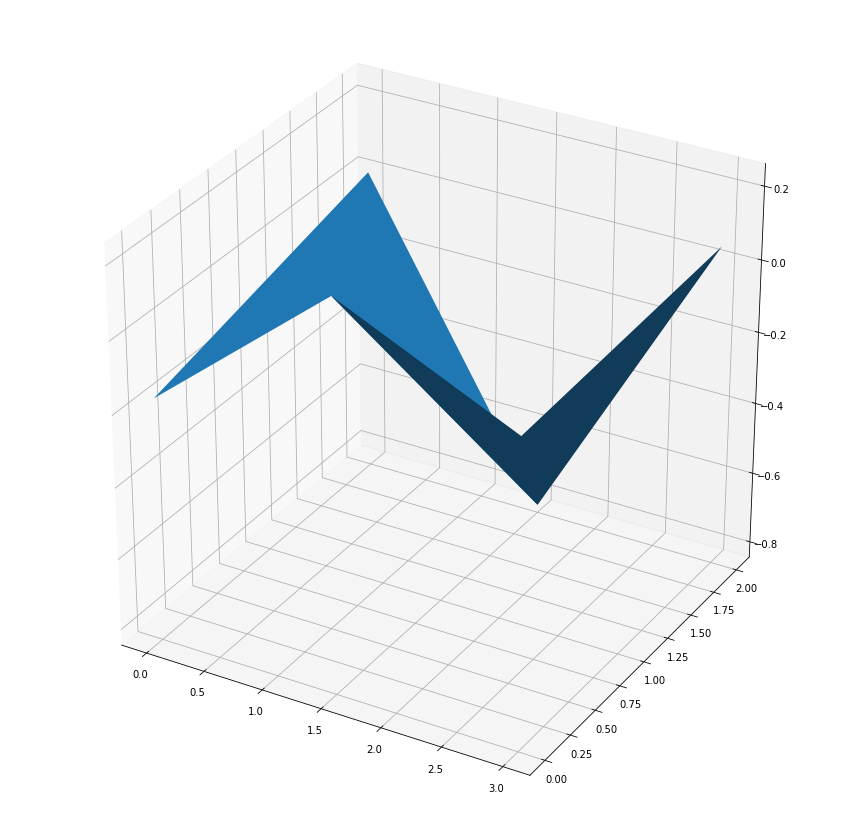

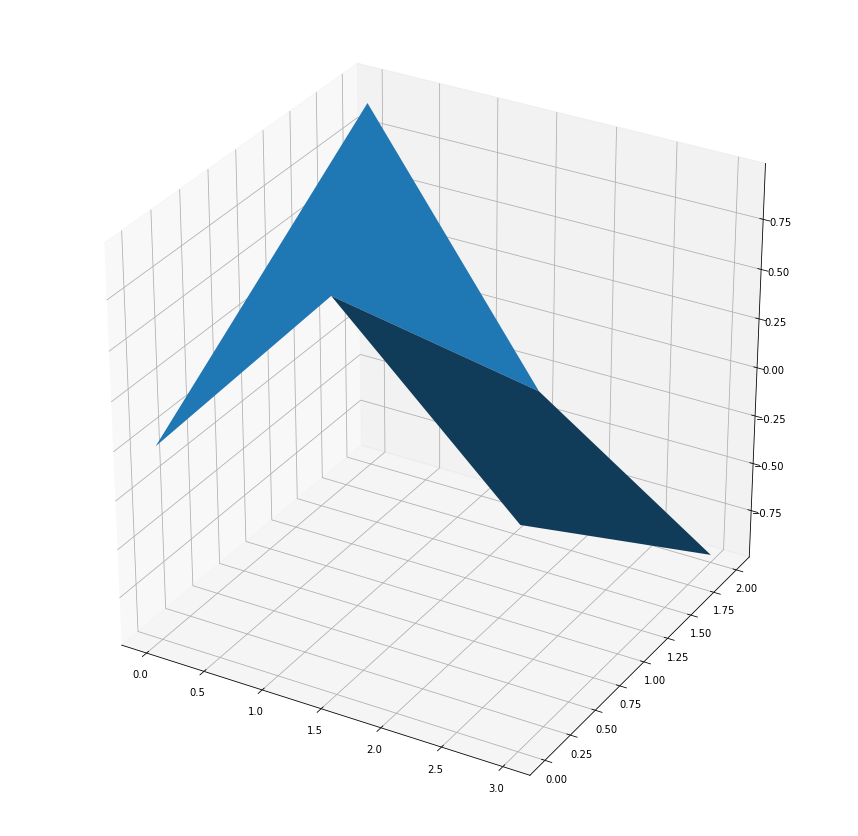

In [8]:
sine_test = grid_domain.vectorize_function(lambda x,y: np.sin(x+y))
product = grid_domain.devectorize_vector(MA.assembled * sine_test)
init = grid_domain.devectorize_function(lambda x,y: np.sin(x+y))

visual.plot_surface_unstructured_w_dict(
    point_val_dict=grid_domain.devectorize_vector(MA.assembled * sine_test),
    plot_domain_shape=grid_domain.domain_size,
    int_domain_shape=grid_domain.integer_size
)

visual.plot_surface_unstructured_w_dict(
    point_val_dict=grid_domain.devectorize_function(lambda x,y: np.sin(x+y)),
    plot_domain_shape=grid_domain.domain_size,
    int_domain_shape=grid_domain.integer_size
)

In [15]:
partial_diff_test(matrix=MA.assembled.toarray(), point=grid_domain.normal_index[2], pointnum=2, pointdict=grid_domain.pointwise_index)

X derivative: 0.16666666586845338
Y derivative: -0.0018181493651754817
XX derivative: -0.01388888728347734
YY derivative: -0.010253044390102365
XY_derivative: 0.0018181483927618286



In [16]:
partial_diff_test(matrix=pipka.toarray(), point=grid_domain.normal_index[38], pointnum=38, pointdict=grid_domain.pointwise_index)

X derivative: 0.8333332069485426
Y derivative: 1.5133157473673498e-08
XX derivative: -0.13888880462891237
YY derivative: -0.1388889057372543
XY_derivative: -5.838882620456953e-09



In [11]:
dist = distributed_eye_easy(ma.get_cell_list_of_ddofs(cell=cell3), axis2shape=MA.assembly_interface.get_ddof_count())

In [12]:
pipka = dist.T * csr_matrix(MA._get_local_gg_matrix(distribution='lobatto', order=3)) * dist

In [ ]:
MA.assembled[33].toarray()

In [ ]:
pipka[33].toarray()

In [ ]:
grid_domain.normal_index